In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import platform



if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'Arial Unicode MS'
elif platform.system() == 'Windows':
    plt.rcParams["font.family"] = 'SimHei'
else:
    pass

### Reprojection 

In [4]:
map_data = gpd.read_file(filename="./data/json/100000_full.json")
map_data['geometry'] = map_data.buffer(0)  # 修复拓扑错误
# map_data.head()

Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3
Skipping field acroutes: unsupported OGR type: 1


In [12]:
map_data.crs.to_string()

'EPSG:4326'

In [7]:
boundary = gpd.read_file(filename="./data/json/boundary202111.json")
boundary['geometry'] = boundary.buffer(0)
boundary

Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3


,adcode,name,childrenNum,level,parent,geometry
0,100000,中华人民共和国,34,country,"{ ""adcode"": null }","MULTIPOLYGON (((110.43346 21.17128, 110.43161 ..."


In [8]:
boundary.bounds

,minx,miny,maxx,maxy
0,73.502355,3.397162,135.09567,53.563269


In [10]:
boundary.crs.to_string()

'EPSG:4326'

In [ ]:
def reproject(map, epsg=3857):

    print(f"original crs: {map.crs}")
    if map.crs is None:
        raise ValueError("Without crs, please set crs first")
    if map.crs.to_epsg() != epsg:
        map_projected = map.to_crs(epsg=epsg)
        print(f"reprojected crs: {map_projected.crs}")

    centroid_projected = map_projected.centroid
    centroid_geo = centroid_projected.to_crs(epsg=4326)
    central_longitude = centroid_geo[0].x
    central_latitude = centroid_geo[0].y
    print(f"central_longitude: {central_longitude}, central_latitude: {central_latitude}")

    lambert_ccrs = ccrs.LambertConformal(central_longitude=central_longitude,
                                     central_latitude=central_latitude)
    return lambert_ccrs



In [65]:
lambert_ccrs = reproject(boundary)

original crs: EPSG:4326
reprojected crs: EPSG:3857
central_longitude: 104.19151209290295, central_latitude: 37.46842480653838


In [54]:
boundary_lambert = boundary.to_crs(lambert_ccrs.proj4_init)
boundary_lambert

,adcode,name,childrenNum,level,parent,geometry
0,100000,中华人民共和国,34,country,"{ ""adcode"": null }","MULTIPOLYGON (((674376.757 -1804321.951, 67410..."


In [ ]:
lambert_ccrs = reproject(map_data)   # 

map_data_lambert = map_data.to_crs(lambert_ccrs.proj4_init)
# map_data_lambert

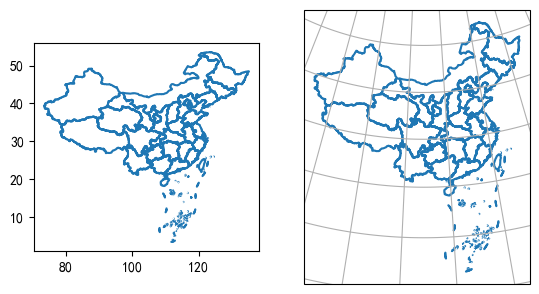

In [ ]:
ax1 = plt.subplot(121)
map_data.boundary.plot(ax=ax1)
ax2 = plt.subplot(122, projection=lambert_ccrs)
map_data_lambert.boundary.plot(ax=ax2)
ax2.gridlines()

### Reprojection of GeoDataFrame

In [68]:
sample_data = pd.DataFrame({'lon':np.linspace(start=100, stop=105, num=100),
                            'lat':np.linspace(start=30, stop=40, num=100),
                            'show_value':np.random.rand(100)})

In [69]:
print(boundary.crs)

EPSG:4326


In [ ]:
# create a GeoDataFrame example
sample_data_gpd = gpd.GeoDataFrame(   
    sample_data,
    geometry=gpd.points_from_xy(x=sample_data['lon'], y=sample_data['lat']),
    crs= boundary.crs
)
sample_data_gpd

,lon,lat,show_value,geometry
0,100.000000,30.00000,0.431315,POINT (100 30)
1,100.050505,30.10101,0.595866,POINT (100.05051 30.10101)
2,100.101010,30.20202,0.267468,POINT (100.10101 30.20202)
3,100.151515,30.30303,0.808263,POINT (100.15152 30.30303)
4,100.202020,30.40404,0.075857,POINT (100.20202 30.40404)
...,...,...,...,...
95,104.797980,39.59596,0.633714,POINT (104.79798 39.59596)
96,104.848485,39.69697,0.438054,POINT (104.84848 39.69697)
97,104.898990,39.79798,0.346053,POINT (104.89899 39.79798)
98,104.949495,39.89899,0.597894,POINT (104.94949 39.89899)


In [ ]:
# reproject the sample_data_gpd
sample_data_gpd = sample_data_gpd.to_crs(lambert_ccrs.proj4_init)
sample_data_gpd

,lon,lat,show_value,geometry
0,100.000000,30.00000,0.431315,POINT (-406956.008 -818531.62)
1,100.050505,30.10101,0.595866,POINT (-401542.485 -807498.196)
2,100.101010,30.20202,0.267468,POINT (-396141.476 -796464.252)
3,100.151515,30.30303,0.808263,POINT (-390752.979 -785429.766)
4,100.202020,30.40404,0.075857,POINT (-385376.988 -774394.716)
...,...,...,...,...
95,104.797980,39.59596,0.633714,POINT (51809.771 235077.978)
96,104.848485,39.69697,0.438054,POINT (56043.643 246261.909)
97,104.898990,39.79798,0.346053,POINT (60265.097 257448.549)
98,104.949495,39.89899,0.597894,POINT (64474.129 268637.923)


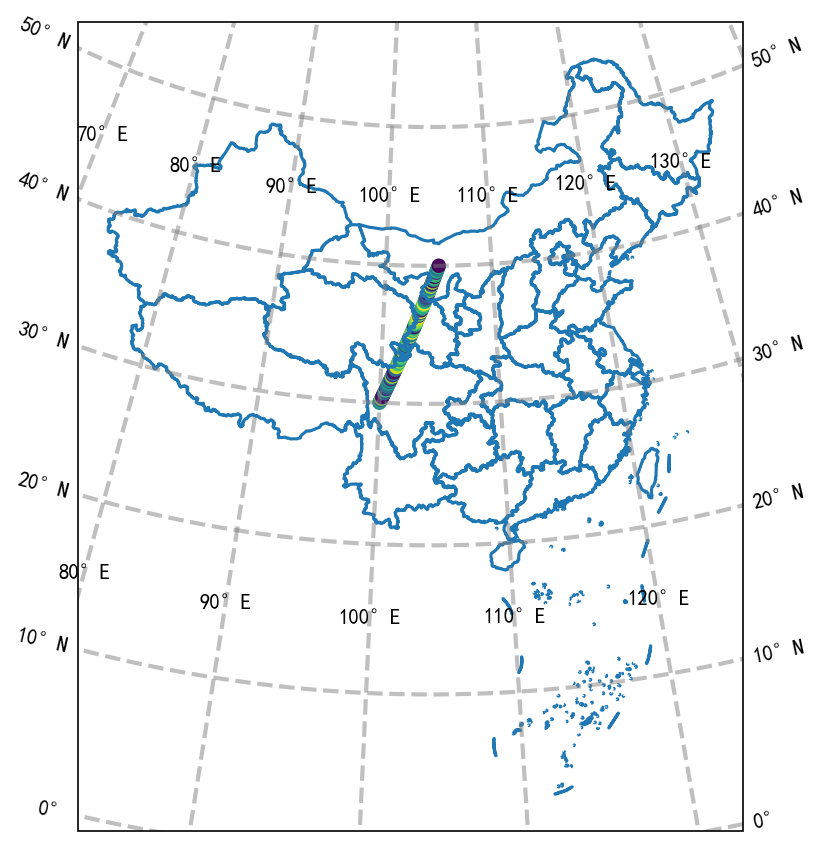

In [72]:
fig, ax = plt.subplots(subplot_kw={'projection': lambert_ccrs}, figsize=(7,7), dpi=150)
sample_data_gpd.plot(ax=ax, column='show_value')
map_data_lambert.boundary.plot(ax=ax)
ax.gridlines(draw_labels=True,
             linewidth=2, color='gray', alpha=0.5, linestyle='--')